In [114]:
from common_imports import *
from helper import *

# To plot pretty figures
# %matplotlib widget

In [115]:
import hdbscan
import seaborn as sns
from sklearn import metrics
from s_dbw import S_Dbw

# %matplotlib inline
# sns.set_context('poster')
sns.set_style('white')
sns.set_color_codes()
plot_kwds = {'alpha' : 0.5, 's' : 80, 'linewidths':0}

### Generating Gaussian Blobs

In [116]:
# Get split returns a generator
# List comprehension is one way to evaluate a generator

_ , data_samples, training_labels, original_labels = simulate_blobs(class_size=4000)

# Separating a hold out set that will be used for validation later
X_train, y_train, y_original, X_valid, y_valid, y_valid_original = split_valid(data_samples, original_labels, training_labels)


print("Train Size:", X_train.shape)
print("Test Size:", y_train.shape)


hot_encoder = dfHotEncoder()
hot_encoder.fit(training_labels)
print("Categories:", hot_encoder.categories_)

Creating data...
Train Size: (4000, 2)
Test Size: (4000,)
Categories: [array([0, 1])]


In [117]:
MODEL_ZOO = []
ZSCALERS = []
MODELDIR = "models/"
INITFILE = MODELDIR+"init.h5"
BASENAME = MODELDIR+"dnn"

def build_dnn(num_features, num_nodes = 16, depth = 2, num_labels=2, activation = "elu"):
    
    import tensorflow as tf
    import keras
#     keras.backend.clear_session()
    
    nn = keras.models.Sequential()
    Dense = keras.layers.Dense
    
    # Using He initialization
    he_init = tf.keras.initializers.he_uniform()
    
    nn.add(Dense(units = num_nodes, activation=activation, input_dim=num_features,
                kernel_initializer=he_init))
    
    for i in range(1,depth):
        nn.add(Dense(units = num_nodes, activation=activation,
                    kernel_initializer=he_init))

    nn.add(Dense(units=num_labels, activation= "softmax",
                kernel_initializer=he_init))
    
    nn.compile(loss="categorical_crossentropy",
                  optimizer='sgd',
                  metrics=['accuracy'])
    
    return nn

def train_model(model, X, y, epochs=30, batch_size=20, verbose=0):
    from sklearn.preprocessing import StandardScaler
    from imblearn.over_sampling import SMOTE
    
    model.load_weights(INITFILE)
    
    ZScaler = StandardScaler().fit(X)
    
    X_train = ZScaler.transform(X)
    y_train = hot_encoder.transform(y)

    history = model.fit(X_train, y_train, epochs=epochs, batch_size = batch_size, verbose=verbose)
    

    return history, ZScaler

'''
Assumes categorical output from DNN
'''
def getCorrectPredictions(model, samples, labels, enc):
    import numpy as np
    
    predictions = model.predict(samples)
    preds = np.array([np.argmax(x) for x in predictions])
    true_labels = np.array([x for x in labels])

    correct = preds == true_labels
    
    return samples[correct], labels[correct], correct


In [118]:
def runDNN(depth, epochs, train_data, test_data,foldnum):
    import innvestigate
    import innvestigate.utils as iutils
    
    X_train, y_train = train_data
    X_test, y_test = test_data
    num_features = X_train.shape[1]
    
    nn = build_dnn(num_features)


    history, ZScaler = train_model(nn, X_train, y_train,
                                   epochs=epochs, batch_size=20)

    scaled_samples = ZScaler.transform(X_test)
    final_acc = nn.evaluate(scaled_samples, hot_encoder.transform(y_test), verbose=0)

    # Getting all the samples that can be correctly predicted
    all_samples, _labels, correct_idxs = getCorrectPredictions(nn, scaled_samples, y_test, enc = hot_encoder)

    # Stripping the softmax activation from the model
    model_w_softmax = nn
    model = iutils.keras.graph.model_wo_softmax(model_w_softmax)

    # Creating an analyzer
    lrp_E = innvestigate.analyzer.relevance_based.relevance_analyzer.LRPEpsilon(model=model, epsilon=1e-3)
    lrp_results = lrp_E.analyze(all_samples)
    
    model.save_weights(
        "{basename}_{id}.h5".format(basename=BASENAME, id=foldnum)
    )
    
    ZSCALERS.append(ZScaler)
    
    
    return (final_acc, lrp_results, correct_idxs)

def runCV(depth,epochs, X, y, y_original):
    
#     start_time = time()
    cv_original_labels = []
    cv_lrp_results = []
    cv_testing_indxs = []
    
    for i, (train_index, test_index) in enumerate(getKF(X, y_original)):

        X_train = X.iloc[train_index]
        y_train = y.iloc[train_index]
        X_test  = X.iloc[test_index]
        y_test = y.iloc[test_index]
        y_test_original = y_original.iloc[test_index]

        final_acc, lrp_results, correct_predictions = runDNN(depth, epochs, train_data = [X_train,y_train], test_data = [X_test, y_test], foldnum=i)

        cv_original_labels.extend(y_test_original[correct_predictions])
        cv_lrp_results.extend(lrp_results)
        cv_testing_indxs.extend(test_index[correct_predictions])

        print("{}/{}, Fold {} scores: loss={:0.3f} accuracy={:.4f}".format(
            depth, epochs, i, final_acc[0], final_acc[1]))

#     print("{}/{} Runtime: {:.3f}s".format(depth, epoch, time()-start_time))

    return (cv_lrp_results, cv_original_labels, cv_testing_indxs)

In [119]:
MODEL_ZOO = []
ZSCALERS = []
NUMCV = 10
%time cv_lrp_results, cv_original_labels, cv_testing_indxs = runCV(depth=5,epochs=10, X=X_train, y=y_train, y_original=y_original)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
5/10, Fold 0 scores: loss=0.009 accuracy=1.0000
5/10, Fold 1 scores: loss=0.010 accuracy=1.0000
5/10, Fold 2 scores: loss=0.009 accuracy=1.0000
5/10, Fold 3 scores: loss=0.009 accuracy=1.0000
5/10, Fold 4 scores: loss=0.010 accuracy=1.0000
5/10, Fold 5 scores: loss=0.009 accuracy=1.0000
5/10, Fold 6 scores: loss=0.011 accuracy=1.0000
5/10, Fold 7 scores: loss=0.010 accuracy=1.0000
5/10, Fold 8 scores: loss=0.008 accuracy=1.0000
5/10, Fold 9 scores: loss=0.009 accuracy=1.0000
CPU times: user 30.9 s, sys: 5.88 s, total: 36.8 s
Wall time: 23.7 s


## Plotting LRP

In [120]:
from scipy.stats import entropy
'''
Expects data to be 2D numpy array
'''
def calculateEntropy(data, plot=False):
    from scipy.stats import entropy
    
    nsamples = len(data)
    nbins = 30

    xedges = np.linspace(0,15,nbins+1)
    yedges = np.linspace(0,15,nbins+1)
    
    x = np.clip(data[:,0], xedges[0], xedges[-1])
    y = np.clip(data[:,1], yedges[0], yedges[-1])
    
    grid, xedges, yedges = np.histogram2d(x, y, bins=[xedges,yedges])
    densities = (grid/nsamples).flatten()
    
    if plot:
        fig, ax = plt.subplots(1, figsize=(8, 8))

        ax.imshow(grid, interpolation='nearest', origin='low',
                    extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], cmap="jet")
#         plt.colorbar()
        plt.show()
    
    return entropy(densities)

In [121]:
type(np.array(cv_original_labels))

numpy.ndarray

In [122]:
outer_ring = y_train.iloc[cv_testing_indxs]==0
outer_ring_lrp = np.array(cv_lrp_results)[outer_ring]

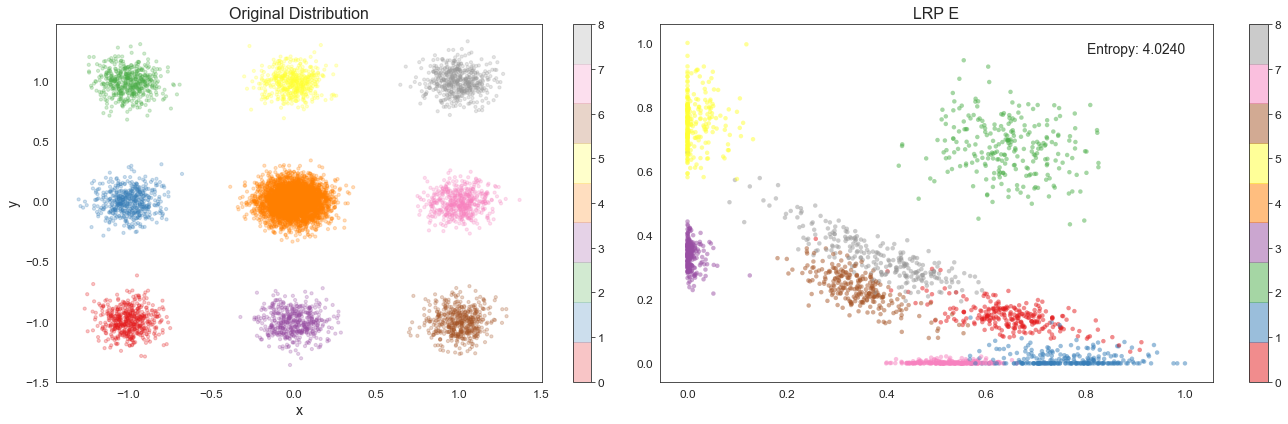

In [193]:
from sklearn.preprocessing import MinMaxScaler
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import cm

plt.close("Positive Only LRP")
fig, axs = plt.subplots(1,2, figsize=(18,6), num="Positive Only LRP")

cmap = "Set1" #"Paired"
plot_args = {"kind":"scatter", "x":0,  "y":1, "c":"label", "cmap": cmap, "s":10, "alpha":0.25}
plot_args["c"] = original_labels

data_samples.plot(ax=axs[0],title="Original Distribution", **plot_args)

data = np.clip(outer_ring_lrp, 0,None)
lrp_entropy = calculateEntropy(data)

sdata = MinMaxScaler().fit_transform(data)

divider = make_axes_locatable(axs[1])
cax = divider.append_axes('right', size='3.5%', pad=0.5)

_a = axs[1].scatter(*sdata.T, s=20, linewidth=0, c=np.array(cv_original_labels)[outer_ring], alpha=0.5, cmap=plot_args["cmap"])
axs[1].set_title("LRP E")
axs[1].text(0.95,0.95,"Entropy: {:.4f}".format(lrp_entropy),
            horizontalalignment='right', verticalalignment='top',
            fontsize=14, transform=axs[1].transAxes)

fig.colorbar(_a,cax=cax, orientation='vertical')

plt.tight_layout()
plt.show()

In [179]:
_a

# Beginning Clustering using accelerated HDBSCAN*

In [124]:
# Score for original dataset
score_orig = S_Dbw(data_samples.values, original_labels, centers_id=None, method='Halkidi',
centr='mean', nearest_centr=True, metric='euclidean')
score_orig

0.1599028414948201

# Plotting Clustering Performance

## Defining Function for Scoring Clusters

In [133]:
def clusterPerf(data, labels, cluster_sizes):

    plt.close("Cluster Comparison")
    fig, axs = plt.subplots(1+len(cluster_sizes), 1, figsize=(16,8*(1+len(cluster_sizes))), num="Cluster Comparison")
    plt.title("Cluster Comparison")


    axs[0].scatter(*data.T, s=50, linewidth=0, c=labels, alpha=0.5, cmap="Set1")
    axs[0].set_title("Original Distribution")

    _metrics = []

    for i,size in enumerate(cluster_sizes):
        clusterer = hdbscan.HDBSCAN(min_cluster_size=size)
        clusterer.fit(data)
        cluster_labels = clusterer.labels_

         ## Number of clusters in labels, ignoring noise if present.
        num_clusters = cluster_labels.max() + 1

        color_palette = sns.color_palette("bright", num_clusters)
        cluster_colors = [color_palette[x] if x >= 0
                          else (0, 0, 0)
                          for x in clusterer.labels_]
        cluster_member_colors = [sns.desaturate(x, p) for x, p in
                                 zip(cluster_colors, clusterer.probabilities_)]

        print(cluster_labels)
        
        noise, halkidi_s_Dbw, halkidi_ignore_noise, halkidi_bind, sil_score = [np.NaN]*5
        
        noise = list(cluster_labels).count(-1)/len(cluster_labels)
        
        if num_clusters > 1:
            halkidi_s_Dbw = S_Dbw(data, cluster_labels, alg_noise="comb", method='Halkidi',
                        centr='mean', nearest_centr=True, metric='euclidean')

            halkidi_ignore_noise = S_Dbw(data, cluster_labels, alg_noise="filter", method='Halkidi',
                        centr='mean', nearest_centr=True, metric='euclidean')

            halkidi_bind = S_Dbw(data, cluster_labels, alg_noise="bind", method='Halkidi',
                        centr='mean', nearest_centr=True, metric='euclidean')

            sil_score = metrics.silhouette_score(data, cluster_labels, metric="euclidean")

        _metrics.append([num_clusters,noise,sil_score, halkidi_s_Dbw, halkidi_ignore_noise, halkidi_bind])
        
        axs[i+1].scatter(*data.T, s=50, linewidth=0, c=cluster_member_colors, alpha=0.6)
        axs[i+1].set_title("Minimum Cluster Size: {}".format(size))
        axs[i+1].text(0.95,0.95,"Clusters Found: {}".format(num_clusters),
                    horizontalalignment='right', verticalalignment='top',
                    fontsize=14, transform=axs[i+1].transAxes)

    # plt.tight_layout()
    plt.show()
    scores = pd.DataFrame(_metrics, columns=["Clusters", "Noise", "Silhouette","Halkidi", "Halkidi-Filtered Noise", "Halkidi-Bounded Noise"], index=cluster_sizes)
    
    return scores

In [134]:
noise, halkidi_s_Dbw, halkidi_ignore_noise = [np.NaN]*3

In [135]:
noise, halkidi_s_Dbw, halkidi_ignore_noise

(nan, nan, nan)

In [136]:
print([np.NaN for x in range(5,21,5)])

# Fixed bbug with cross validation only testing on val set

print(np.argmax([-1,0,np.NaN]))
print(np.max([-1,0,np.NaN]))
# np.max([-1,0,None,np.NaN]) # Cant compare None with ints

[nan, nan, nan, nan]
2
nan


[2 3 4 ... 3 4 5]
[0 6 3 ... 6 3 4]
[ 0  6  4 ...  6 -1  3]
[ 1  5  4 ... -1  3  3]
[ 1  5 -1 ... -1 -1  3]
[1 3 3 ... 3 3 3]
[1 2 2 ... 2 2 2]
[ 1  3  3 ...  3 -1  4]
[1 3 3 ... 3 3 3]
[1 3 3 ... 3 3 3]
[0 1 1 ... 1 1 1]
[-1  1  1 ...  1  1  1]
[-1 -1 -1 ... -1 -1 -1]
[-1 -1 -1 ... -1 -1 -1]
[-1 -1 -1 ... -1 -1 -1]


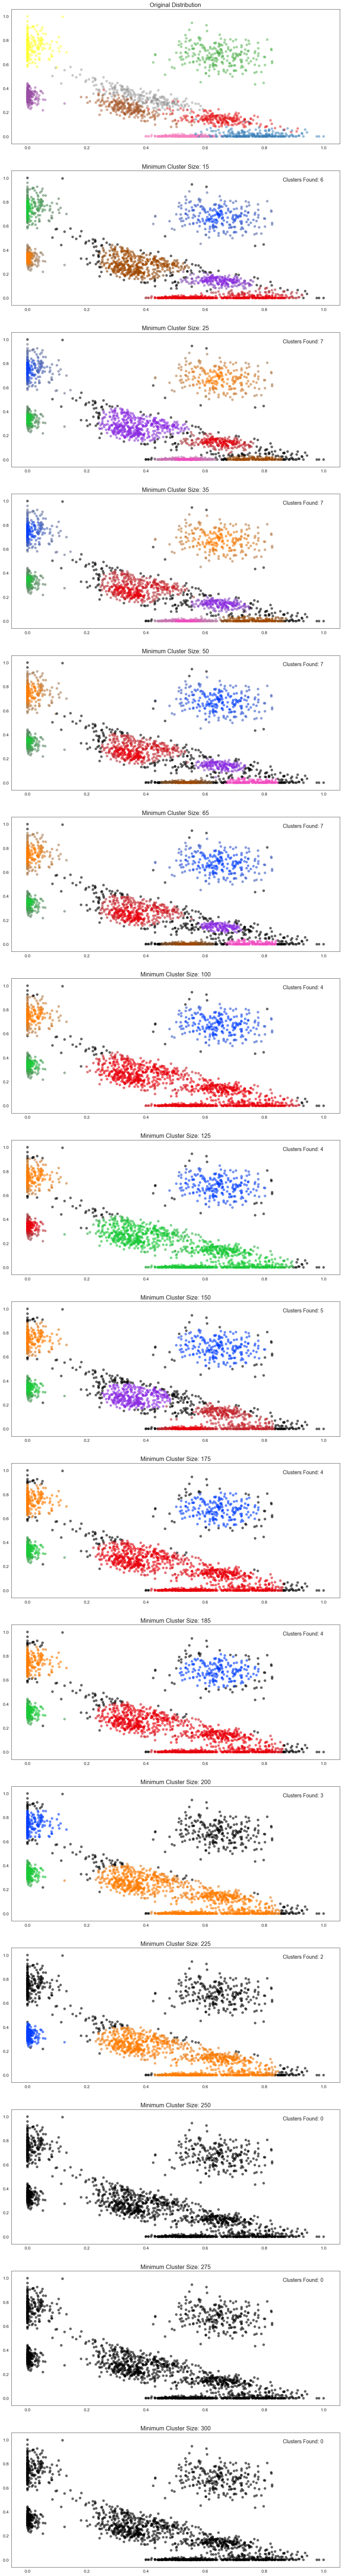

,Clusters,Noise,Silhouette,Halkidi,Halkidi-Filtered Noise,Halkidi-Bounded Noise
15,6,0.0590,0.489627,0.527127,0.384328,0.434893
25,7,0.0975,0.544175,0.520962,0.346663,0.415717
35,7,0.1020,0.548262,0.514357,0.348618,0.417958
50,7,0.1460,0.509846,0.516417,0.322835,0.416967
65,7,0.1580,0.497280,0.529144,0.316566,0.416849
100,4,0.0280,0.550017,0.771526,0.507874,0.553105
125,4,0.0405,0.539167,0.777758,0.492053,0.551704
150,5,0.1605,0.496892,0.536148,0.260427,0.374575
175,4,0.0790,0.499691,0.765242,0.465022,0.555495
185,4,0.0895,0.490462,0.755885,0.455946,0.555495


In [137]:
data = np.clip(outer_ring_lrp, 0,None)
sdata = MinMaxScaler().fit_transform(data)
labels = np.array(cv_original_labels)[outer_ring]
cluster_sizes = [15,25,35,50,65,100,125,150,175,185,200,225,250,275,300]

scores = clusterPerf(sdata, labels, cluster_sizes)
scores

In [138]:
# p

/Users/Work/anaconda3/envs/condatensor/lib/python3.6/site-packages/pandas/plotting/_core.py:1801: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  plot_obj.generate()


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a3f417f60>,
      dtype=object)

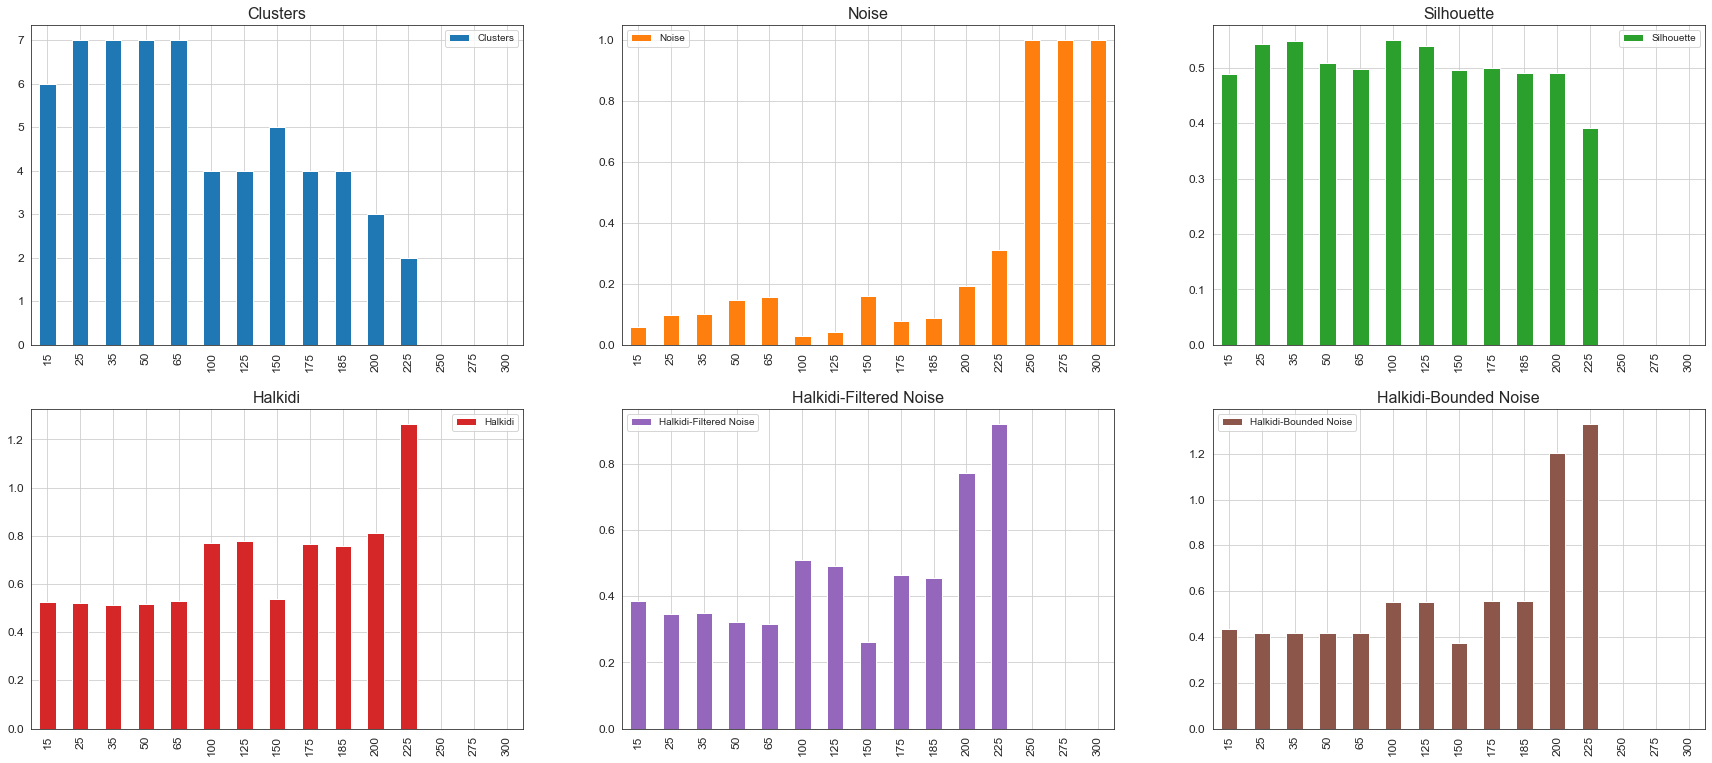

In [139]:
plt.close("Cluster Scores")
fig, axs = plt.subplots(figsize=(30,20), num="Cluster Scores")
plt.title("Cluster Scores")

scores.plot(kind="bar", ax=axs, subplots=True, layout=(3,3), grid=True)

In [140]:
# plt.savefig(figures_dir+"cluster_perf_score.png")

In [141]:
scores.idxmin()

Clusters                  250
Noise                     100
Silhouette                225
Halkidi                    35
Halkidi-Filtered Noise    150
Halkidi-Bounded Noise     150
dtype: int64

# Applying Linear Classifier on Clusters

In [151]:
scores.loc[35]

Clusters                  7.000000
Noise                     0.102000
Silhouette                0.548262
Halkidi                   0.514357
Halkidi-Filtered Noise    0.348618
Halkidi-Bounded Noise     0.417958
Name: 35, dtype: float64

In [156]:
minsize = int(scores["Halkidi-Filtered Noise"].idxmin())
# minsize = 65

In [157]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=minsize, prediction_data=True)
clusterer.fit(sdata)
clusterer

HDBSCAN(algorithm='best', allow_single_cluster=False, alpha=1.0,
        approx_min_span_tree=True, cluster_selection_method='eom',
        core_dist_n_jobs=4, gen_min_span_tree=False, leaf_size=40,
        match_reference_implementation=False, memory=Memory(location=None),
        metric='euclidean', min_cluster_size=150, min_samples=None, p=None,
        prediction_data=True)

### Generate outputs form DNN

### Prediction array is num_samples x num_models x [prediction, softmax_probability]
> Pick the highest "confidence" and its corresponding prediction

In [158]:
# Get the model architecture
num_features = X_train.shape[1]
model = build_dnn(num_features)

In [159]:
predictions = []
for i,zscaler in enumerate(ZSCALERS):
    model.load_weights(
    "{basename}_{id}.h5".format(basename=BASENAME, id=i))
    _samples = zscaler.transform(X_valid)
    model_preds = np.array([(np.argmax(x), np.max(x)) for x in model.predict(_samples)])
    predictions.append(model_preds)

# Combine all DNN predictions into a matrix
predictions = np.stack(predictions, axis=1)
predictions

array([[[1.        , 0.99695873],
        [1.        , 0.99673623],
        [1.        , 0.99688393],
        ...,
        [1.        , 0.99702066],
        [1.        , 0.99683291],
        [1.        , 0.99705279]],

       [[0.        , 0.99976581],
        [0.        , 0.99966764],
        [0.        , 0.99971515],
        ...,
        [0.        , 0.99977642],
        [0.        , 0.99971348],
        [0.        , 0.99975067]],

       [[1.        , 0.99148214],
        [1.        , 0.99268734],
        [1.        , 0.99236357],
        ...,
        [1.        , 0.99174654],
        [1.        , 0.99210149],
        [1.        , 0.99203074]],

       ...,

       [[0.        , 0.99984896],
        [0.        , 0.99987006],
        [0.        , 0.99986744],
        ...,
        [0.        , 0.99986959],
        [0.        , 0.99987924],
        [0.        , 0.99988973]],

       [[0.        , 0.99999952],
        [0.        , 0.99999976],
        [0.        , 0.99999964],
        .

-- # TODO: Drop values which were predicted incorrectly
-- > just set them to [-1,-1]

### Scale it according to the min/max of the training dataset

In [160]:
best_DNN = np.argmax(predictions[:,:,1], axis=1)
best_predictions = predictions[range(len(X_valid)), best_DNN,0].astype(int)

### Run LRP using best DNN for each sample 

In [161]:
best_DNN

array([9, 7, 3, ..., 5, 1, 9])

In [162]:
# def runAnalysis(nn, sample):
#     model_w_softmax = nn
#     model = iutils.keras.graph.model_wo_softmax(model_w_softmax)

#     # Creating an analyzer
#     lrp_E = innvestigate.analyzer.relevance_based.relevance_analyzer.LRPEpsilon(model=model, epsilon=1e-3)

#     return lrp_E.analyze(sample)

NUMCV = 10
lrp_zoo = []
for dnn_idx in range(NUMCV):
    model.load_weights(
    "{basename}_{id}.h5".format(basename=BASENAME, id=dnn_idx))
    model_w_softmax = model
    model_wo_softmax = iutils.keras.graph.model_wo_softmax(model_w_softmax)

    # Creating an analyzer
    lrp_zoo.append(
        innvestigate.analyzer.relevance_based.relevance_analyzer.LRPEpsilon(
        model=model_wo_softmax, epsilon=1e-3))

print("Loaded LRP models...")

analyze = lambda idx,x: lrp_zoo[idx].analyze(x.reshape(1,-1))

Loaded LRP models...


In [163]:
val_set_lrp = []

for dnn_idx, sample in zip(best_DNN, X_valid.values):
    val_set_lrp.extend(analyze(dnn_idx,sample))

### Assign a cluster to all the points in the validation set when possible

In [164]:
lrp_data = np.clip(outer_ring_lrp, 0,None)
mmscaler = MinMaxScaler().fit(lrp_data)

data  = np.clip(val_set_lrp,0,None)
sdata = MinMaxScaler().fit_transform(data)
cluster_labels, strengths = hdbscan.approximate_predict(clusterer, sdata)

In [165]:
cluster_labels

array([-1, -1, -1, ..., -1, -1, -1])

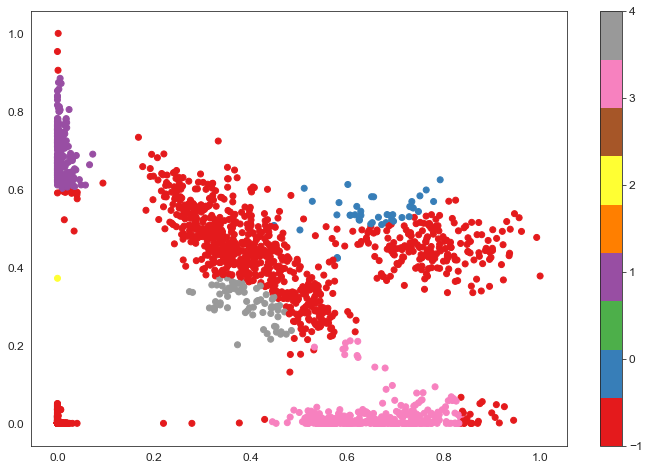

In [171]:
# xvals = [x[0] for x in val_set_lrp]
# yvals = [x[1] for x in val_set_lrp]
fig = plt.figure(figsize=(12,8))
plt.scatter(*sdata.T, c=cluster_labels, cmap="Set1")
plt.colorbar()

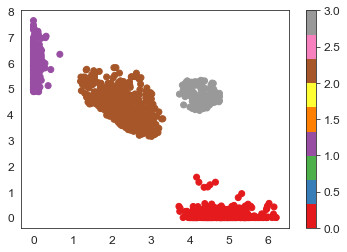

In [75]:
clustered_points = cluster_labels > -1
plt.scatter(*data[clustered_points].T, c=cluster_labels[clustered_points], cmap="Set1")
plt.colorbar()

In [76]:
len(X_valid[clustered_points])

1382

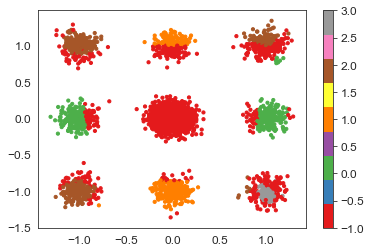

In [79]:
plt.scatter(X_valid["x"], X_valid["y"], c=cluster_labels, s=plot_args["s"], cmap=plot_args["cmap"])
plt.colorbar()

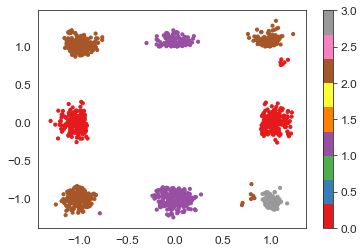

In [95]:
class_B = X_valid[clustered_points]
class_B_labels = cluster_labels[clustered_points]
plt.scatter(class_B["x"], class_B["y"], c=class_B_labels, s=plot_args["s"], cmap=plot_args["cmap"])
plt.colorbar()

## Performing a one-vs-rest type analysis
### Center Blob vs Surrounding Subclasses

In [126]:
cluster_labels.shape

(4000,)

In [173]:
a=[1,2,3,4,5,]
a[99:]

[]

In [114]:
center_class = X_valid[y_valid == 1]
center_labels = cluster_labels[ y_valid == 1]

# Separate training set for each class with
# equal amounts of subcluster and center blob
xtrain = {}
start = 0
for i in range(0,cluster_labels.max()+1):
    
    _subclass = X_valid[cluster_labels == i]
    _labels = cluster_labels[ cluster_labels == i]
    
    end = start+len(_subclass)
    _xtrain = np.concatenate((center_class[start:end], _subclass))
    _ytrain = np.concatenate((center_labels[start:end], _labels))
    
    xtrain[i] = (_xtrain, _ytrain)
    start += len(_subclass)

In [121]:
# xtrain[1][0][:5]==xtrain[0][0][:5]

### Establishing Baseline

In [122]:
def split_valid(features, training_labels, original_labels=None, valid_size=0.5):
    train_index, validation_index = get_split_index(features, training_labels, test_size=valid_size)[0]
    
    X_valid, y_valid = features[validation_index], training_labels[validation_index], 
    X_train, y_train = features[train_index], training_labels[train_index]
    
    y_original = None
    y_valid_original = None
    
    if original_labels:
        y_original = original_labels[train_index]
        y_valid_original = original_labels[validation_index]
        
    return X_train, y_train, y_original, X_valid, y_valid, y_valid_original

In [136]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

# Drop samples not associated with a cluster
outer_pts = X_valid[clustered_points]
inner_circle = center_class[:len(outer_pts)]

X_valid_reduced = np.concatenate([outer_pts, inner_circle])
y_valid_reduced = np.concatenate([y_valid[clustered_points], center_labels[:len(outer_pts)]])

y_valid_reduced

array([ 0,  0,  0, ..., -1, -1, -1])

In [137]:
# X_valid[cluster_labels > -1]
# y_valid_reduced = y_valid[cluster_labels > -1]

svm_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("SVM", LinearSVC(**{'C': 10, 'loss': 'hinge', 'max_iter': 10000000, 'tol': 0.0001}))
])

%time svm_clf.fit(X_train, y_train)
print("Linear SVM Test Accuracy: {:0.3f}".format(svm_clf.score(X_valid, y_valid)))

%time _score = cross_val_score(svm_clf, X = X_valid_reduced, y=y_valid_reduced, cv=10)
print("SVM Accuracy: {:0.3f}(+/- {:.3f})".format(_score.mean(), _score.std()*2))

CPU times: user 23.9 ms, sys: 2.41 ms, total: 26.3 ms
Wall time: 24.9 ms
Linear SVM Test Accuracy: 0.688
CPU times: user 347 ms, sys: 2.46 ms, total: 350 ms
Wall time: 351 ms
SVM Accuracy: 0.715(+/- 0.041)


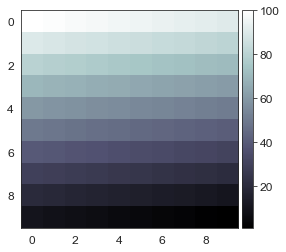

In [174]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

data = np.arange(100, 0, -1).reshape(10, 10)

fig, ax = plt.subplots()
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)

im = ax.imshow(data, cmap='bone')

fig.colorbar(im, cax=cax, orientation='vertical')
plt.show()

In [157]:
(1/3 + 1/2 + 2/3)

1.5

In [159]:
scores = []
sizes = [len(xtrain[i][1]) for i in xtrain]

for i in xtrain:
    print("\tSubcluster",i)
#     _xtrain, _ytrain, _ , _xvalid, _yvalid, _ = split_valid(xtrain[i][0], xtrain[i][1],valid_size=0.1)
    print("Size:", sizes[i] )
    
    %time _score = cross_val_score(svm_clf, X = xtrain[i][0], y=xtrain[i][1], cv=10)
    
#     %time svm_clf.fit(_xtrain, _ytrain)
    scores.append(_score)
    print("SVM Accuracy: {:0.3f}(+/- {:.3f})".format(_score.mean(), _score.std()*2))
    
print("----------------------")
# subcluster_avg = np.mean([s.mean() for s in scores])
# print("Mean Score: {:0.4f}".format(subcluster_avg))

# This is actually the "true" mean: sum(correctly classified) / (total samples)
weighted_avg = sum([sz*sc.mean() for sz,sc in zip(sizes,scores)])/sum(sizes)
print("Weighted Mean: {:0.4f}".format(weighted_avg))

	Subcluster 0
Size: 822
CPU times: user 197 ms, sys: 3.21 ms, total: 200 ms
Wall time: 199 ms
SVM Accuracy: 0.766(+/- 0.092)
	Subcluster 1
Size: 720
CPU times: user 123 ms, sys: 1.22 ms, total: 124 ms
Wall time: 124 ms
SVM Accuracy: 0.824(+/- 0.067)
	Subcluster 2
Size: 1014
CPU times: user 118 ms, sys: 220 µs, total: 118 ms
Wall time: 118 ms
SVM Accuracy: 0.896(+/- 0.037)
	Subcluster 3
Size: 208
CPU times: user 14.4 ms, sys: 257 µs, total: 14.7 ms
Wall time: 14.5 ms
SVM Accuracy: 1.000(+/- 0.000)
----------------------
Weighted Mean: 0.8466


### Getting the best parameters for the data using a grid search

In [210]:
from sklearn.model_selection import cross_val_score


param_grid = [
    {"dual":[False],"max_iter":[10000000], "penalty":["l1","l2"], "tol":[1e-4,1e-5,1e-6], "C":[1,10,100]},
    { "max_iter":[10000000], "loss":["squared_hinge"], "tol":[1e-4,1e-5,1e-6], "C":[1,10,100]},
    { "max_iter":[10000000], "loss":["hinge"], "tol":[1e-4,1e-5,1e-6], "C":[1,10,100]}
]

lsvc = LinearSVC()
clf = Pipeline([
    ("scaler", StandardScaler()),
    ("SVMGrid",GridSearchCV(lsvc, param_grid, cv=10, iid=False, scoring="neg_mean_squared_error", n_jobs=4))
])

scores = []
for i in xtrain:
    print("\tSubcluster",i)

    %time clf.fit(xtrain[i][0], xtrain[i][1])
    
    grid = clf.steps[1][1]
    print(grid.best_params_)

    svm_clf = Pipeline([
        ("scaler", StandardScaler()),
        ("SVM", LinearSVC(**grid.best_params_))
    ])
    
    _score = cross_val_score(svm_clf, X = xtrain[i][0], y=xtrain[i][1], cv=10)

    scores.append(_score)
    
    print("SVM Accuracy: {:0.3f}(+/- {:.3f})".format(_score.mean(), _score.std()*2))

    
print("----------------------")
subcluster_avg = np.mean([s.mean() for s in scores])
print("Mean Score: {:0.4f}".format(subcluster_avg))

	Subcluster 1
CPU times: user 150 ms, sys: 8.52 ms, total: 159 ms
Wall time: 48.4 s
{'C': 10, 'loss': 'hinge', 'max_iter': 10000000, 'tol': 0.0001}
SVM Accuracy: 0.747(+/- 0.061)
	Subcluster 2
CPU times: user 106 ms, sys: 3.34 ms, total: 109 ms
Wall time: 23.9 s
{'C': 1, 'loss': 'hinge', 'max_iter': 10000000, 'tol': 0.0001}
SVM Accuracy: 0.844(+/- 0.052)
	Subcluster 3
CPU times: user 161 ms, sys: 5.75 ms, total: 166 ms
Wall time: 1min 23s
{'C': 10, 'loss': 'hinge', 'max_iter': 10000000, 'tol': 0.0001}
SVM Accuracy: 0.632(+/- 0.155)


	Subcluster 1
CPU times: user 150 ms, sys: 8.52 ms, total: 159 ms

Wall time: 48.4 s

{'C': 10, 'loss': 'hinge', 'max_iter': 10000000, 'tol': 0.0001}

SVM Accuracy: 0.747(+/- 0.061)


	Subcluster 2
CPU times: user 106 ms, sys: 3.34 ms, total: 109 ms

Wall time: 23.9 s

{'C': 1, 'loss': 'hinge', 'max_iter': 10000000, 'tol': 0.0001}

SVM Accuracy: 0.844(+/- 0.052)

Subcluster 3

CPU times: user 161 ms, sys: 5.75 ms, total: 166 ms

Wall time: 1min 23s

{'C': 10, 'loss': 'hinge', 'max_iter': 10000000, 'tol': 0.0001}

SVM Accuracy: 0.632(+/- 0.155)

Mean: 0.7411

In [243]:
# np.mean([s.mean() for s in scores])

### For the original dataset, the defaults are best

In [107]:
# param_grid = [
#     {"dual":[False],"max_iter":[1000000], "penalty":["l1","l2"], "tol":[1e-4,1e-5,1e-6], "C":[1,10,100]},
#     { "max_iter":[1000000], "loss":["squared_hinge"], "tol":[1e-4,1e-5,1e-6], "C":[1,10,100]},
#     { "max_iter":[1000000], "loss":["hinge"], "tol":[1e-4,1e-5,1e-6], "C":[1,10,100]}
# ]

# lsvc = LinearSVC()
# clf = Pipeline([
#     ("scaler", StandardScaler()),
#     ("SVMGrid",GridSearchCV(lsvc, param_grid, cv=10, scoring="neg_mean_squared_error", n_jobs=8))
# ])
# %time clf.fit(X_train,y_train)

# grid = clf.steps[1][1]
# best_params = grid.best_params_
# best_params # {'C': 1, 'loss': 'hinge', 'max_iter': 1000000, 'tol': 0.0001}

# svm_clf = Pipeline([
#     ("scaler", StandardScaler()),
#     ("SVM", LinearSVC(**best_params))
# ])

# %time svm_clf.fit(X_train, y_train)
# print("Linear SVM Test Accuracy: {:0.3f}".format(svm_clf.score(X_valid, y_valid)))

### SVM Accuracies

Original Data: 0.681

Clustered Data Avg: 0.741

## Trying Kernel SVC
> Ignoring Gaussian since data is derived from Gaussian

In [161]:
from sklearn.svm import SVC

nlsvm = SVC()

nlsvm_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("SVM", SVC(kernel="poly", C=1, gamma="scale", degree=3))
])

%time nlsvm_clf.fit(X_train, y_train)
print("SVM Test Accuracy: {:0.3f}".format(nlsvm_clf.score(X_valid, y_valid)))

%time _score = cross_val_score(nlsvm_clf, X = X_valid_reduced, y=y_valid_reduced, cv=10)
print("SVM Test* Accuracy: {:0.3f}(+/- {:.3f})".format(_score.mean(), _score.std()*2))

CPU times: user 570 ms, sys: 11.5 ms, total: 581 ms
Wall time: 581 ms
SVM Test Accuracy: 0.637
CPU times: user 2.6 s, sys: 21.9 ms, total: 2.62 s
Wall time: 2.63 s
SVM Test* Accuracy: 0.713(+/- 0.033)


In [160]:
from sklearn.model_selection import cross_val_score
scores = []
for i in xtrain:
    print("\tSubcluster",i)
    %time _score = cross_val_score(nlsvm_clf, X = xtrain[i][0], y=xtrain[i][1], cv=10)
    scores.append(_score)
    print("SVM Accuracy: {:0.3f}(+/- {:.3f})".format(_score.mean(), _score.std()*2))

print("----------------------")
weighted_avg = sum([sz*sc.mean() for sz,sc in zip(sizes,scores)])/sum(sizes)
print("Weighted Mean: {:0.4f}".format(weighted_avg))

	Subcluster 0
CPU times: user 143 ms, sys: 3.6 ms, total: 147 ms
Wall time: 145 ms
SVM Accuracy: 0.674(+/- 0.077)
	Subcluster 1
CPU times: user 109 ms, sys: 711 µs, total: 110 ms
Wall time: 110 ms
SVM Accuracy: 0.724(+/- 0.079)
	Subcluster 2
CPU times: user 53 ms, sys: 578 µs, total: 53.6 ms
Wall time: 53.8 ms
SVM Accuracy: 0.990(+/- 0.018)
	Subcluster 3
CPU times: user 15.3 ms, sys: 174 µs, total: 15.4 ms
Wall time: 15.4 ms
SVM Accuracy: 1.000(+/- 0.000)
----------------------
Weighted Mean: 0.8274


### Non Linear SVM Grid Search on Original Data

In [162]:
# grid = clf.steps[1][1]
# print(grid.best_params_) #{'C': 1, 'coef0': 0.1, 'gamma': 'auto', 'kernel': 'poly', 'shrinking': True}

nlsvm_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("SVM", SVC(**{'C': 1, 'coef0': 0.1, 'gamma': 'auto', 'kernel': 'poly', 'shrinking': True}))
])

%time _score = cross_val_score(nlsvm_clf, X = X_valid, y=y_valid, cv=10)
print("SVM Accuracy: {:0.3f}(+/- {:.3f})".format(_score.mean(), _score.std()*2))

%time _score = cross_val_score(nlsvm_clf, X = X_valid_reduced, y=y_valid_reduced, cv=10)
print("SVM Accuracy: {:0.3f}(+/- {:.3f})".format(_score.mean(), _score.std()*2))

CPU times: user 121 ms, sys: 2.85 ms, total: 124 ms
Wall time: 123 ms
SVM Accuracy: 1.000(+/- 0.000)
CPU times: user 39.7 ms, sys: 252 µs, total: 40 ms
Wall time: 39.9 ms
SVM Accuracy: 1.000(+/- 0.000)


### Using best params for original dataset on subclusters

In [163]:
from sklearn.model_selection import cross_val_score
scores = []
for i in xtrain:
    print("\tSubcluster",i)
    %time _score = cross_val_score(nlsvm_clf, X = xtrain[i][0], y=xtrain[i][1], cv=10)
    scores.append(_score)
    print("SVM Accuracy: {:0.3f}(+/- {:.3f})".format(_score.mean(), _score.std()*2))

print("----------------------")
subcluster_avg = np.mean([s.mean() for s in scores])
print("Mean Score: {:0.4f}".format(subcluster_avg))

	Subcluster 0
CPU times: user 55.6 ms, sys: 2.75 ms, total: 58.4 ms
Wall time: 56.6 ms
SVM Accuracy: 1.000(+/- 0.000)
	Subcluster 1
CPU times: user 52.5 ms, sys: 461 µs, total: 53 ms
Wall time: 52.9 ms
SVM Accuracy: 1.000(+/- 0.000)
	Subcluster 2
CPU times: user 24.6 ms, sys: 153 µs, total: 24.8 ms
Wall time: 24.8 ms
SVM Accuracy: 1.000(+/- 0.000)
	Subcluster 3
CPU times: user 14.2 ms, sys: 226 µs, total: 14.4 ms
Wall time: 14.2 ms
SVM Accuracy: 1.000(+/- 0.000)
----------------------
Mean Score: 1.0000


In [231]:
param_grid = [
    {"kernel":["poly"],"gamma":["auto", "scale"], "shrinking":[True,False], "coef0":[0,1e-1,1,3,10], "C":[1,10,100]}
#     {"kernel":["poly"], "degree":[3,4,5], "gamma":["auto", "scale"], "shrinking":[False], "tol":[1e-4,1e-5,1e-6], "C":[1,10,100]},
]

nlsvc = SVC()

clf = Pipeline([
    ("scaler", StandardScaler()),
    ("SVMGrid",GridSearchCV(nlsvc, param_grid, cv=10, iid=False, scoring="neg_mean_squared_error", n_jobs=4))
])

nlsvm_scores = []
for i in xtrain:
    print("\tSubcluster",i)

    %time clf.fit(xtrain[i][0], xtrain[i][1])
    
    grid = clf.steps[1][1]
    print(grid.best_params_)

    svm_clf = Pipeline([
        ("scaler", StandardScaler()),
        ("SVM", SVC(**grid.best_params_))
    ])
    
    _score = cross_val_score(svm_clf, X = xtrain[i][0], y=xtrain[i][1], cv=10)

    nlsvm_scores.append(_score)
    
    print("SVM Accuracy: {:0.3f}(+/- {:.3f})".format(_score.mean(), _score.std()*2))
    
    
# 	Subcluster 1
# CPU times: user 353 ms, sys: 68.2 ms, total: 421 ms
# Wall time: 5min 8s
# {'C': 10, 'coef0': 3, 'gamma': 'auto', 'kernel': 'poly', 'shrinking': True}
# SVM Accuracy: 0.998(+/- 0.010)
# 	Subcluster 2
# CPU times: user 229 ms, sys: 5.26 ms, total: 234 ms
# Wall time: 2.54 s
# {'C': 1, 'coef0': 10, 'gamma': 'auto', 'kernel': 'poly', 'shrinking': True}
# SVM Accuracy: 1.000(+/- 0.000)
# 	Subcluster 3
# CPU times: user 354 ms, sys: 10.1 ms, total: 364 ms
# Wall time: 4min 52s
# {'C': 1, 'coef0': 10, 'gamma': 'auto', 'kernel': 'poly', 'shrinking': True}
# SVM Accuracy: 0.998(+/- 0.010)

	Subcluster 1
CPU times: user 353 ms, sys: 68.2 ms, total: 421 ms
Wall time: 5min 8s
{'C': 10, 'coef0': 3, 'gamma': 'auto', 'kernel': 'poly', 'shrinking': True}
SVM Accuracy: 0.998(+/- 0.010)
	Subcluster 2
CPU times: user 229 ms, sys: 5.26 ms, total: 234 ms
Wall time: 2.54 s
{'C': 1, 'coef0': 10, 'gamma': 'auto', 'kernel': 'poly', 'shrinking': True}
SVM Accuracy: 1.000(+/- 0.000)
	Subcluster 3
CPU times: user 354 ms, sys: 10.1 ms, total: 364 ms
Wall time: 4min 52s
{'C': 1, 'coef0': 10, 'gamma': 'auto', 'kernel': 'poly', 'shrinking': True}
SVM Accuracy: 0.998(+/- 0.010)


In [232]:
subcluster_avg = np.mean([s.mean() for s in nlsvm_scores])
print("Mean Score: {:0.4f}".format(subcluster_avg))

Mean Score: 0.9984


### Intracluster classification

## As an extra validation step, checking to see if the subclusters themselves are separable
> Necessary but not sufficient condition

In [150]:
def combinations(num):
    for i in range(num):
        for j in range(i+1,num):
            yield (i,j)

scores=[]
for i,j in combinations(len(xtrain)):
    i,j = i, j
    print("\tComparing: {},{}".format(i,j))
    subgroup_pair = np.logical_or(cluster_labels==i, cluster_labels==j)
    _xtrain = X_valid[subgroup_pair]
    _ytrain = cluster_labels[subgroup_pair]
    
    %time _score = cross_val_score(svm_clf, X=_xtrain, y=_ytrain, cv=10)
    scores.append(_score)
    print("SVM Accuracy: {:0.3f}(+/- {:.3f})".format(_score.mean(), _score.std()*2))
    
print("----------------------")
intracluster_avg = np.mean([s.mean() for s in scores])
print("Mean Score: {:0.4f}".format(intracluster_avg))

	Comparing: 0,1
CPU times: user 164 ms, sys: 2.1 ms, total: 166 ms
Wall time: 167 ms
SVM Accuracy: 0.835(+/- 0.063)
	Comparing: 0,2
CPU times: user 296 ms, sys: 1.9 ms, total: 298 ms
Wall time: 299 ms
SVM Accuracy: 0.676(+/- 0.092)
	Comparing: 0,3
CPU times: user 38.7 ms, sys: 376 µs, total: 39.1 ms
Wall time: 39 ms
SVM Accuracy: 1.000(+/- 0.000)
	Comparing: 1,2
CPU times: user 114 ms, sys: 735 µs, total: 114 ms
Wall time: 115 ms
SVM Accuracy: 0.878(+/- 0.046)
	Comparing: 1,3
CPU times: user 43.1 ms, sys: 399 µs, total: 43.5 ms
Wall time: 43.7 ms
SVM Accuracy: 1.000(+/- 0.000)
	Comparing: 2,3
CPU times: user 49.7 ms, sys: 359 µs, total: 50.1 ms
Wall time: 50.2 ms
SVM Accuracy: 0.989(+/- 0.026)
----------------------
Mean Score: 0.8963


In [299]:
# a=combinations(4)
# next(a),next(a)

((0, 1), (0, 2))

# Pickling Zscalers

In [17]:
ZSCALERS

[StandardScaler(copy=True, with_mean=True, with_std=True),
 StandardScaler(copy=True, with_mean=True, with_std=True),
 StandardScaler(copy=True, with_mean=True, with_std=True),
 StandardScaler(copy=True, with_mean=True, with_std=True),
 StandardScaler(copy=True, with_mean=True, with_std=True),
 StandardScaler(copy=True, with_mean=True, with_std=True),
 StandardScaler(copy=True, with_mean=True, with_std=True),
 StandardScaler(copy=True, with_mean=True, with_std=True),
 StandardScaler(copy=True, with_mean=True, with_std=True),
 StandardScaler(copy=True, with_mean=True, with_std=True)]

In [19]:
zs = ZSCALERS[1]
orig_scaled = zs.transform(X_valid)
orig_scaled

NameError: name 'ZSCALERS' is not defined

In [17]:
import dill

with open("ztest.pickle", "wb") as pf:
    dill.dump(zs,pf)

NameError: name 'zs' is not defined

In [18]:
with open("ztest.pickle", "rb") as pf:
    pzs = dill.load(pf)


EOFError: Ran out of input

In [36]:
pzs

StandardScaler(copy=True, with_mean=True, with_std=True)

In [37]:
pkl_scaled = pzs.transform(X_valid)
pkl_scaled

array([[ 0.03057285,  0.00701649],
       [-1.60871716, -1.52886718],
       [-0.24676934, -0.20329945],
       ...,
       [-1.83352998,  1.72819633],
       [ 1.63587417,  1.85421978],
       [ 0.10930827,  0.00561914]])

In [38]:
(orig_scaled == pkl_scaled).all()

True

In [1]:
a=[1,2,3,5]
a[-2:]

[3, 5]

In [11]:
a=[]
b=[3]
if a: print(1)
if b: print(2)

2


In [15]:
"a{b}{c}"

'a{b}{c}'

In [26]:
a=X_valid.values

In [43]:
(a>0).all()

False

In [44]:
pos_only=np.logical_and(a[:,0]>0, a[:,1]>0)
(a[pos_only]> 0).all()

True

In [45]:
a[pos_only] = 100

In [53]:
a[pos_only].shape

(1002, 2)

In [54]:
X_valid.shape

(4000, 2)

In [83]:
b=np.stack((X_valid.values, 0*X_valid.values, -1*X_valid.values ), axis=1)
b

array([[[ 100.        ,  100.        ],
        [   0.        ,    0.        ],
        [-100.        , -100.        ]],

       [[  -0.99433501,   -0.94703072],
        [  -0.        ,   -0.        ],
        [   0.99433501,    0.94703072]],

       [[  -0.15073136,   -0.12515228],
        [  -0.        ,   -0.        ],
        [   0.15073136,    0.12515228]],

       ...,

       [[  -1.13358624,    1.07241366],
        [  -0.        ,    0.        ],
        [   1.13358624,   -1.07241366]],

       [[ 100.        ,  100.        ],
        [   0.        ,    0.        ],
        [-100.        , -100.        ]],

       [[ 100.        ,  100.        ],
        [   0.        ,    0.        ],
        [-100.        , -100.        ]]])

In [84]:
np.logical_and(a[:,0]>0, a[:,1]>0)

array([ True, False, False, ..., False,  True,  True])

### First element of 3rd dimension for each sample

In [89]:
b[:,:,0]

array([[ 100.        ,    0.        , -100.        ],
       [  -0.99433501,   -0.        ,    0.99433501],
       [  -0.15073136,   -0.        ,    0.15073136],
       ...,
       [  -1.13358624,   -0.        ,    1.13358624],
       [ 100.        ,    0.        , -100.        ],
       [ 100.        ,    0.        , -100.        ]])

In [90]:
(b[:,:,0] > 0)

array([[ True, False, False],
       [False, False,  True],
       [False, False,  True],
       ...,
       [False, False,  True],
       [ True, False, False],
       [ True, False, False]])

### Column-wise *and*

In [96]:
(b[:,:,0] > 0).all(axis=1)

array([False, False, False, ..., False, False, False])

In [99]:
len(b)

4000

In [102]:
b.shape

(4000, 3, 2)